<a href="https://colab.research.google.com/github/arifanf/MSIB21/blob/main/D63_Time_Series_Statistical_Approach_(Female_Birth).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 63 - Rabu, 17 November 2021

Dataset : [Birth Female](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)



# Analisa Time Series

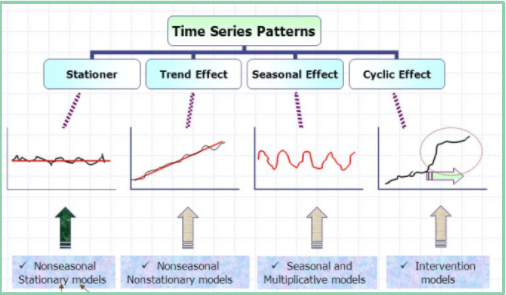


## Import Library dan Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

--2021-11-18 01:11:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘daily-total-female-births.csv’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2021-11-18 01:11:29 (54.9 MB/s) - ‘daily-total-female-births.csv’ saved [6220/6220]



In [ ]:
#Load data
data = pd.read_csv('daily-total-female-births.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

         Date  Births
0  1959-01-01      35
1  1959-01-02      32
2  1959-01-03      30
3  1959-01-04      31
4  1959-01-05      44

 Data Types:
Date      object
Births     int64
dtype: object


In [ ]:
#Mengubah tanggal menjadi index
con=data['Date']
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

In [ ]:
data

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [ ]:
#convert to time series:
ts = data['Births']
ts.head(10)

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
1959-01-06    29
1959-01-07    45
1959-01-08    43
1959-01-09    38
1959-01-10    27
Name: Births, dtype: int64

## Ploting data


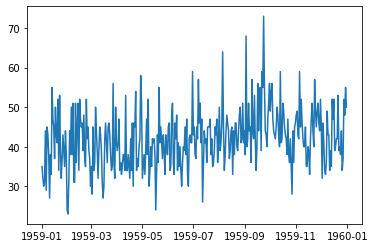

In [ ]:
plt.plot(ts)

## Uji Stasioneritas

Ho : data tidak stasioner

Ha : data stasioner

In [ ]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

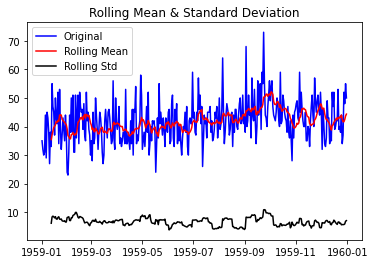

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [ ]:
#Menguji data
test_stationarity(ts)

Terlihat meansnya terus berubah sehingga tidak bisa disebut stasioner. Menurut uji Dickey-Fuller, p-value = 0.99 > 0.05, sehingga Ho gagal ditolak, data tidak stasioner. Nah kita harus melakukan transformasi atau differencing

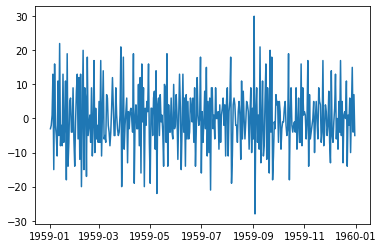

In [ ]:
#Melakukan differencing pertama
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

Terlihat masih belum stasioner, boleh coba differencing sekali lagi atau coba lanjutkan ke transformasi log

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


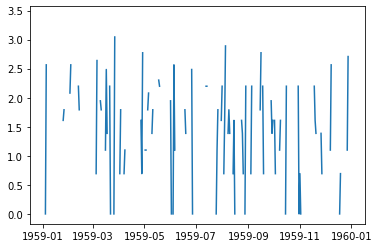

In [ ]:
#Mencoba melakukan transformasi log
ts_log_dif = np.log(ts_diff_1)
plt.plot(ts_log_dif)

Ternyata tidak lebih baik. Sekarang coba data awal yang ditransformasi log

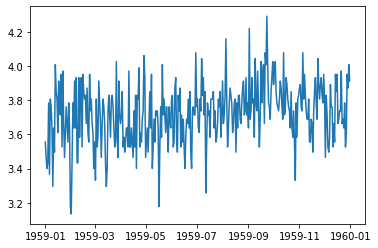

In [ ]:
#Mencoba melakukan transformasi log
ts_log = np.log(ts)
plt.plot(ts_log)

Masih belum stasioner, tetapi secara varians terlihat lebih baik. Sekarang coba data yang ini didifferencing

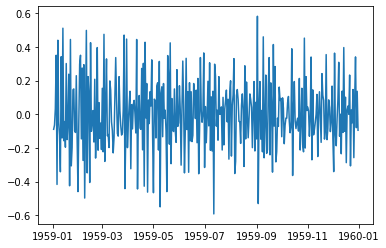

In [ ]:
#Melakukan differencing setelah transform log
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

Sepertinya sudah stasioner, sekarang coba uji Dickey-Fuller supaya lebih meyakinkan

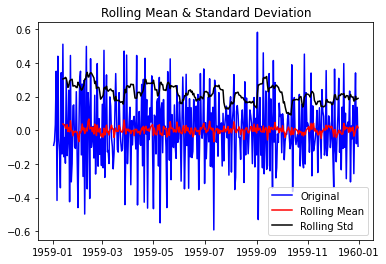

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


In [ ]:
test_stationarity(ts_log_1)

Jika menggunakan alpha 10%, nilai p-value < alpha sehingga sudah memenuhi syarat stasioner. Jadi untuk mempersingkat waktu kita gunakan hasil ini dengan tingkat kepercayaan 90%.

## ACF & PACF

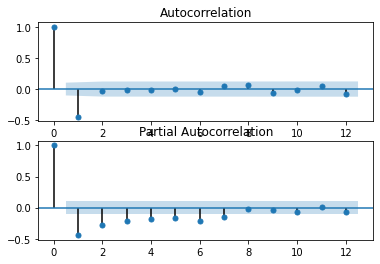

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts_log_1, ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(ts_log_1, ax=plt.gca(), lags=12)
plt.show()

Terlihat bahwa keduanya cut off lag ke-1, lalu 4, lalu 8, ini menunjukkan pola seasonal (musiman) dengan orde 4. Sehingga kemungkinan modelnya


1. ARIMA(1, 1, 1) (p=1, d=1 karena sudah differencing sekali, q=1)
2. SARIMA(1, 1, 1)4, karena mencapai max/min tiap 4

Dan kombinasi lainnya dengan p=[1, 4, 8], d=1, q=[1, 4, 8]

## Membuat model ARIMA

In [ ]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [ ]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts_log.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.178
ARIMA(0, 0, 1) RMSE=0.168
ARIMA(0, 0, 2) RMSE=0.165
ARIMA(0, 1, 0) RMSE=0.184
ARIMA(0, 1, 1) RMSE=0.163
ARIMA(0, 1, 2) RMSE=0.159
ARIMA(1, 0, 0) RMSE=0.165
ARIMA(1, 0, 1) RMSE=0.161
ARIMA(1, 1, 0) RMSE=0.169
ARIMA(1, 1, 1) RMSE=0.159
ARIMA(1, 1, 2) RMSE=0.162
ARIMA(2, 0, 0) RMSE=0.163
ARIMA(2, 0, 1) RMSE=0.156
ARIMA(2, 0, 2) RMSE=0.159
ARIMA(2, 1, 0) RMSE=0.162
ARIMA(2, 1, 1) RMSE=0.159
ARIMA(2, 1, 2) RMSE=0.160
Best ARIMA(2, 0, 1) RMSE=0.156


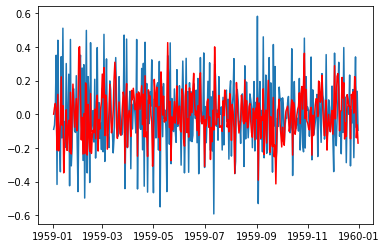

In [ ]:
model_ARIMA = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model_ARIMA.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_log_1)             
plt.plot(predictions_ARIMA_diff, color='red')               #fitting dengan data yang udah difference sekali dan log

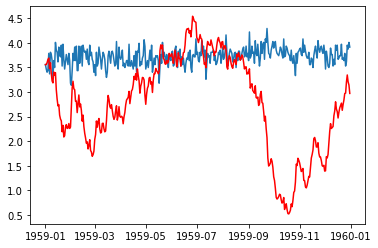

In [ ]:
predictions_ARIMA_diff_cum_sum = predictions_ARIMA_diff.cumsum()                                
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum_sum,fill_value=0)
plt.plot(ts_log)             
plt.plot(predictions_ARIMA_log, color='red')               #fitting dengan data yang ditransformasi log

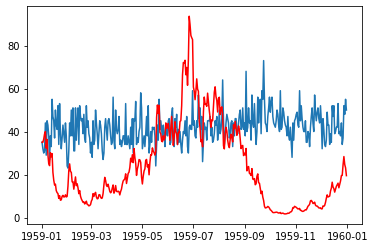

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, color='red')                    #fitting dengan data asli

In [ ]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Births   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 135.286
Method:                       css-mle   S.D. of innovations              0.166
Date:                Thu, 18 Nov 2021   AIC                           -258.572
Time:                        01:18:40   BIC                           -235.189
Sample:                    01-02-1959   HQIC                          -249.278
                         - 12-31-1959                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.000      4.042      0.000       0.000       0.001
ar.L1.D.Births     0.9471        nan        nan        nan         nan         nan
ar.L2.D.Births    -0.0950        nan        nan        nan         nan         nan
ma.L1.D.Births    -1.7813        nan        nan        nan         nan         nan
ma.L2.D.Births     0.7814        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2005           +0.0000j            1.2005            0.0000
AR.2            8.7665           +0.0000j            8.7665            0.0000
MA.1            1.0005           +0.0000j            1.0005            0.0000
MA.2            1.2791           +0.0000j            1.2791            0.0000
-----------------------------------------------------------------------------
"""

## Kombinasi Model dengan Seasonal dan Trend

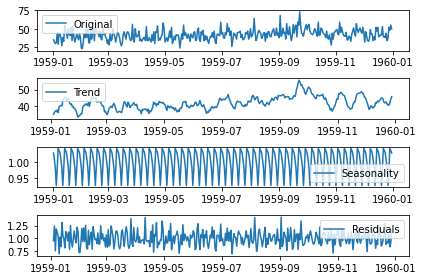

In [ ]:
decomposition = seasonal_decompose(ts, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
train_size = int(len(ts) * 0.7)               #data trainingnya 70%
train, test = ts_log[:train_size], ts_log[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
		model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,4))
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])

# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

0.15969348632365213


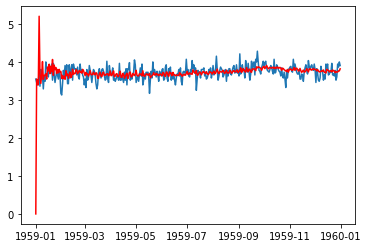

In [ ]:
#Bikin model SARIMA
model_sarima = SARIMAX(ts_log, order=(1,1,1), seasonal_order=(1,1,1,4))
results_SARIMA = model_sarima.fit(disp=-1)
predictions_SARIMA_diff = pd.Series(results_SARIMA.fittedvalues,copy=True)
plt.plot(ts_log)             
plt.plot(predictions_SARIMA_diff, color='red')               #fitting dengan data log

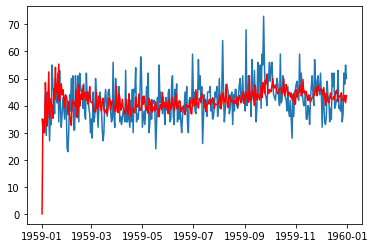

In [ ]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='red')               #fitting dengan data

In [ ]:
results_SARIMA_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            Births   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -1235.729
Date:                           Thu, 18 Nov 2021   AIC                           2483.457
Time:                                   01:21:08   BIC                           2506.774
Sample:                               01-01-1959   HQIC                          2492.729
                                    - 12-31-1959                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -2.082e-06   2.83e-06     -0.735      0.463   -7.64e-06    3.47e-06
ar.L1          0.0863      0.065      1.330      0.184      -0.041       0.213
ma.L1         -0.9894      0.025    -39.509      0.000      -1.038      -0.940
ar.S.L4        0.2376      0.068      3.491      0.000       0.104       0.371
ma.S.L4       -0.9909      0.145     -6.836      0.000      -1.275      -0.707
sigma2        60.2710      8.979      6.713      0.000      42.673      77.869
===================================================================================
Ljung-Box (Q):                       68.56   Jarque-Bera (JB):                 9.00
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.87   Skew:                             0.38
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Membuat prediksi

In [ ]:
#dengan model ARIMA(2,1,2)
predict_dif = results_ARIMA.predict(start=144,end=156)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_log = [ts_log[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data lognya
  a = pred_log[i] + j
  pred_log.append(a)
predict_exp = pd.Series(np.exp(pred_log[1:]), index=predict_dif.index)  #prediksi data aslinya
print(predict_exp)

1959-05-25     49.516143
1959-05-26     52.884864
1959-05-27     53.584465
1959-05-28     56.012516
1959-05-29     69.269242
1959-05-30     80.773723
1959-05-31     94.707061
1959-06-01    116.579198
1959-06-02    130.780217
1959-06-03    132.025289
1959-06-04    154.899448
1959-06-05    204.654205
1959-06-06    233.256351
Freq: D, dtype: float64


In [ ]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=144,end=156)
print(pred_2)

1959-05-25    44.882313
1959-05-26    39.783006
1959-05-27    41.152436
1959-05-28    39.140285
1959-05-29    39.314170
1959-05-30    41.205462
1959-05-31    39.244317
1959-06-01    37.001989
1959-06-02    42.233154
1959-06-03    40.793262
1959-06-04    38.595226
1959-06-05    39.857991
1959-06-06    43.090425
Freq: D, dtype: float64


In [ ]:
ts[-1]

50

In [ ]:
type(ts)

pandas.core.series.Series

In [ ]:
predict_dif

1959-05-25   -0.009724
1959-05-26    0.075543
1959-05-27   -0.052676
1959-05-28    0.031174
1959-05-29    0.168110
1959-05-30   -0.058775
1959-05-31    0.005486
1959-06-01    0.048645
1959-06-02   -0.092835
1959-06-03   -0.105472
1959-06-04    0.150307
1959-06-05    0.118763
1959-06-06   -0.147729
Freq: D, dtype: float64